# Классификация изображений

В данном ноутбуке содержатся примеры применения нейронных сетей для классификация изображений. Ноутбук включает две части.
1. Пример классификации с использованием простейшей полносвязной сети прямого распространения.
2. Пример классификации с использованием простейшей сверточной сети.
 1. Тренировка сети "с нуля".
 2. Использование предварительно обученной сети для выделение признаков и обучение сети поверх этих признаков.
 3. Дообучение предварительно обученной сети (fine tuning).

Все примеры используют Keras в качестве библиотеки для работы с нейросетями.

In [1]:
from keras import models
from keras import optimizers
from keras import losses
from keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


В качестве демонстрационных данных будет использоваться часть выборки из соревнования [Kaggle Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats). Изображения из выборки должны быть заранее разбиты на тренировочное (2000 изображений), проверочное (1000 изображений) и тестовое (1000 изображений) множества, которые расположены, соответственно, в подкаталогах train, validation и test каталога cats_vs_dogs_small.

Для чтения изображений создадим вспомогательные объекты, выполняющие выбор изображений из соответствующих множеств и их предобработку для подачи в нейронную сеть.

In [2]:
# setup folders
train_dir = "cats_vs_dogs_small/train/"
val_dir = "cats_vs_dogs_small/validation/"
test_dir = "cats_vs_dogs_small/test/"

# setup training params
img_h, img_w = (75, 75)
epochs = 30
batch_size = 20

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# with data augmentation
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_h, img_w),
    batch_size=100,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

train_generator_aug = train_datagen_aug.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_h, img_w),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_h, img_w),
    batch_size=20,
    class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (100, 75, 75, 3)
labels batch shape: (100,)


Начнем с простейшей полносвязной сети прямого распространения, состоящей из входного слоя, одного скрытого слоя и выходного слоя из одного нейрона.

In [3]:
def plot_stats(history, title="", color="b"):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, color, label='Training acc ' + title)
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, color, label='Training loss ' + title)
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [23]:
def demo_fcnn(opt):
    """
        Simple fully connected feed forward network for image classification.

    """

    # declare the neural network model
    model = models.Sequential()
    model.add(layers.Reshape((img_h*img_w*3,), input_shape=(img_h, img_w, 3)))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # print information about model
    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
#                   optimizer=opt_name,
                  metrics=['acc'])

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=100,
                                  epochs=100,
                                  validation_data=validation_generator,
                                  validation_steps=50
                                 )
    
#     model.save('cats_and_dogs_fcnn.h5')
    
    plot_stats(history)

    return history
    
# Запустим процесс обучения и подождем...
demo_fcnn()


hist_sgd = demo_fcnn(optimizers.SGD(lr=1e-3))
print("\n")
hist_rmsprop = demo_fcnn(optimizers.RMSprop(lr=1e-4))
print("\n")
hist_adam = demo_fcnn(optimizers.Adam(lr=1e-4))
print("\n")
hist_adadelta = demo_fcnn(optimizers.Adadelta(lr=1e-4))
print("\n")
hist_sgd_nesterov = demo_fcnn(optimizers.SGD(lr=1e-3, nesterov=True))





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 16875)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 300)               5062800   
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 301       
Total params: 5,063,101
Trainable params: 5,063,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 40s 397ms/step - loss: 0.7682 - acc: 0.5575
Epoch 2/100
100/100 [==============================] - 38s 382ms/step - loss: 0.6463 - acc: 0.6275
Epoch 3/100
100/100 [==============================] - 39s 389ms/step - loss: 0.6167 - acc: 0.6610
Epoch 4/100
100/100 [==============================] - 39s 387ms/step - loss: 0.5960 - acc: 0.6

100/100 [==============================] - 38s 381ms/step - loss: 0.6546 - acc: 0.6281
Epoch 50/100
100/100 [==============================] - 38s 379ms/step - loss: 0.6539 - acc: 0.6303
Epoch 51/100
100/100 [==============================] - 38s 381ms/step - loss: 0.6534 - acc: 0.6319
Epoch 52/100
100/100 [==============================] - 38s 379ms/step - loss: 0.6528 - acc: 0.6330
Epoch 53/100
100/100 [==============================] - 38s 383ms/step - loss: 0.6522 - acc: 0.6354
Epoch 54/100
100/100 [==============================] - 38s 380ms/step - loss: 0.6516 - acc: 0.6338
Epoch 55/100
100/100 [==============================] - 38s 379ms/step - loss: 0.6510 - acc: 0.6356
Epoch 56/100
100/100 [==============================] - 38s 380ms/step - loss: 0.6504 - acc: 0.6356
Epoch 57/100
100/100 [==============================] - 38s 380ms/step - loss: 0.6499 - acc: 0.6361
Epoch 58/100
100/100 [==============================] - 38s 379ms/step - loss: 0.6493 - acc: 0.6389
Epoch 59/100


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 128)         147584    
__________

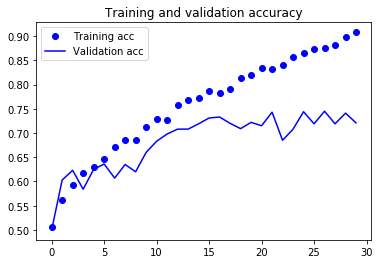

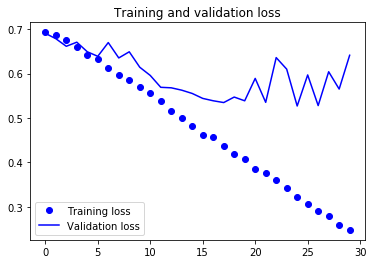

In [36]:
def demo_small_cnn():
    """
    Demonstration of small CNN.

    Create neural network with 3 convolutional and 3 fully connected layers.
    """

    # declare the CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(img_h, img_w, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
#     model.add(layers.Dense(150, activation='relu'))
#     model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # print information about model
    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=100,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  validation_steps=50)
    
    model.save('cats_and_dogs_small_1.h5')

    plot_stats(history)
    
demo_small_cnn()

In [3]:
from keras.applications import VGG16

def demo_pretrained(retrain_conv: bool, train_gen):
    
    conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_h, img_w, 3))
    
    conv_base.trainable = retrain_conv
    
    if retrain_conv:
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block5_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.summary()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=100,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  validation_steps=50)
    
    model.save('cats_and_dogs_alexnet_featurizer.h5')

    plot_stats(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 513       
Total params: 15,764,289
Trainable params: 1,049,601
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 307s 3s/step - loss: 0.5227 - acc: 0.7345 - val_loss: 0.4563 - val_acc: 0.7830
Epoch 2/30
100/100 [==============================] - 299s 3s/step - loss: 0.4162 - acc: 0.8070 - val_loss: 0.4495 - val_

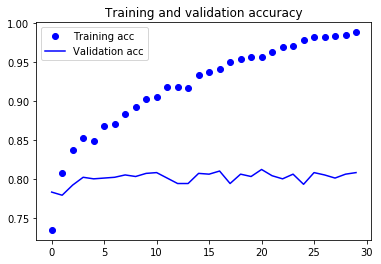

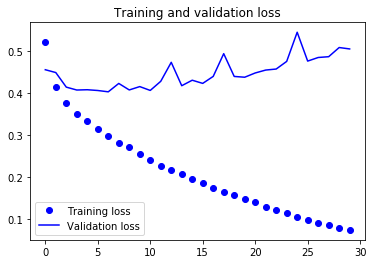

In [ ]:
demo_pretrained(False, train_generator)

In [4]:
demo_pretrained(True, train_generator_aug)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 15,764,289
Trainable params: 8,129,025
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 322s 3s/step - loss: 0.6187 - acc: 0.6810 - val_loss: 0.4465 - val_acc: 0.8130
Epoch 2/30
100/100 [==============================] - 329s 3s/step - loss: 0.5269 - acc: 0.7435 - val_loss: 0.4836 - val_a

NameError: name 'plot_stats' is not defined